In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.optimizers import Adam

2024-07-27 20:45:23.088682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 20:45:23.088802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 20:45:23.278243: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-27 20:45:23.616223: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-27 20:45:25.583565: W tensorflow/compiler/tf2

In [2]:
# Function to load the dataset
def load_dataset(base_path, class_index, image_size):
    images = []
    masks = []
    filenames = []
    for category in class_index:
        category_path = os.path.join(base_path, category)
        if not os.path.exists(category_path):
            raise FileNotFoundError(f"The category path does not exist: {category_path}")
        
        for file in os.listdir(category_path):
            if 'mask' not in file:  # Exclude mask files for image loading
                image_path = os.path.join(category_path, file)
                mask_path = os.path.join(category_path, file.split('.')[0] + '_mask.png')
                
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                if image is not None and mask is not None:
                    if image.shape == mask.shape:
                        image_resized = cv2.resize(image, (image_size, image_size))
                        mask_resized = cv2.resize(mask, (image_size, image_size))
                        images.append(image_resized)
                        masks.append(mask_resized)
                        filenames.append(file)
                    else:
                        print(f"Warning: Image and mask shape mismatch for {file}")
                else:
                    print(f"Warning: Could not load image or mask for {file}")

    return np.array(images), np.array(masks), filenames

In [3]:
# Function to preprocess the images
def preprocess_images(images, masks):
    images = images.astype('float32') / 255.0
    masks = masks.astype('float32') / 255.0
    masks = np.expand_dims(masks, axis=-1)
    return np.expand_dims(images, axis=-1), masks

In [4]:
# U-Net Model Architecture
def unet_model(input_size):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, conv10)

    return model

In [5]:
# Set the base path to the dataset
BASE_PATH = "/home/ubuntu/BSC/Breast_Cancer_Segmentation/Dataset_BUSI_with_GT" # change the path
unique_classes = []

In [6]:
# Check if the path exists and list unique classes
if os.path.exists(BASE_PATH):
    for path in os.listdir(BASE_PATH):
        unique_classes.append(path)
    print("Unique classes found:", unique_classes)
else:
    raise FileNotFoundError(f"The specified path does not exist: {BASE_PATH}")

# Sort classes to ensure consistent order
class_index = sorted(unique_classes)
print("Class index sorted:", class_index)


Unique classes found: ['normal', 'malignant', 'benign']
Class index sorted: ['benign', 'malignant', 'normal']


In [7]:
# Parameters
image_size = 256
images, masks, filenames = load_dataset(BASE_PATH, class_index, image_size)
images, masks = preprocess_images(images, masks)


In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)


In [9]:
# Data augmentation
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [10]:
# Provide the same seed and keyword arguments to the flow methods
seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

In [11]:
image_generator = image_datagen.flow(X_train, batch_size=16, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=16, seed=seed)

In [12]:
# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

In [13]:
# Compile and train the U-Net model
input_size = (image_size, image_size, 1)
model = unet_model(input_size)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, steps_per_epoch=len(X_train) // 16, epochs=50, validation_data=(X_test, y_test))

2024-07-27 20:47:14.544868: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-27 20:47:15.019863: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-27 20:47:15.020195: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/50


2024-07-27 20:47:19.216098: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-27 20:47:19.762055: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-27 20:47:28.262682: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-27 20:47:29.303764: I external/local_xla/xla/service/service.cc:168] XLA service 0x7a746ca32bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-27 20:47:29.303803: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-07-27 20:47:29.333919: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1722113249.495756    2017 device_compiler.h:1

39/39 [==============================] - 65s 941ms/step - loss: 0.3851 - accuracy: 0.9188 - val_loss: 0.2570 - val_accuracy: 0.9272
Epoch 2/50
39/39 [==============================] - 9s 243ms/step - loss: 0.2490 - accuracy: 0.9180 - val_loss: 0.2250 - val_accuracy: 0.9272
Epoch 3/50
39/39 [==============================] - 9s 243ms/step - loss: 0.2345 - accuracy: 0.9177 - val_loss: 0.2075 - val_accuracy: 0.9272
Epoch 4/50
39/39 [==============================] - 9s 243ms/step - loss: 0.2202 - accuracy: 0.9185 - val_loss: 0.2143 - val_accuracy: 0.9272
Epoch 5/50
39/39 [==============================] - 9s 244ms/step - loss: 0.2166 - accuracy: 0.9185 - val_loss: 0.1967 - val_accuracy: 0.9272
Epoch 6/50
39/39 [==============================] - 10s 244ms/step - loss: 0.2050 - accuracy: 0.9191 - val_loss: 0.1900 - val_accuracy: 0.9272
Epoch 7/50
39/39 [==============================] - 10s 244ms/step - loss: 0.2095 - accuracy: 0.9221 - val_loss: 0.1833 - val_accuracy: 0.9370
Epoch 8/50
39/

In [14]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

5/5 [==============================] - 1s 133ms/step - loss: 0.1185 - accuracy: 0.9621
Test Accuracy: 96.21%
Test Loss: 0.1185


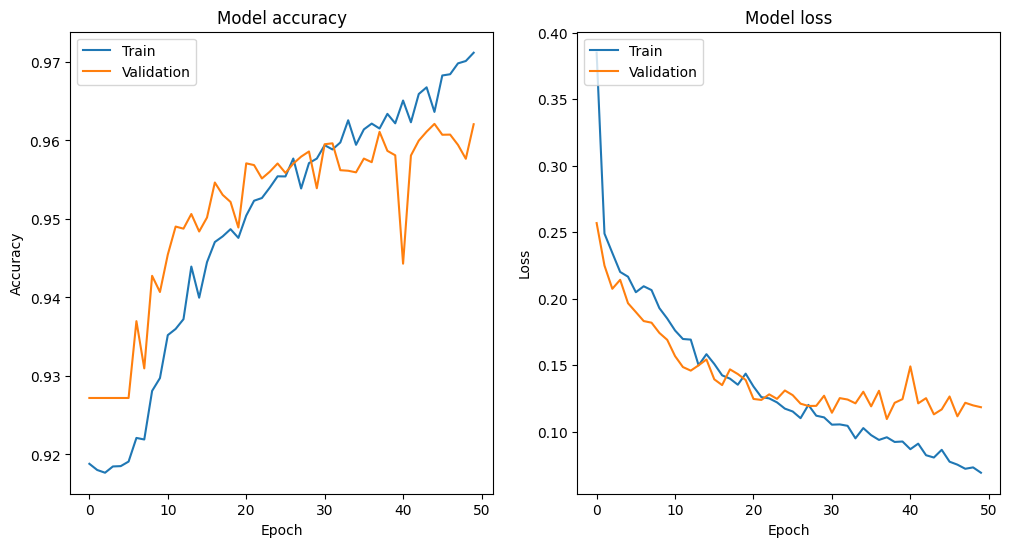

In [15]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [16]:
# Visualize some predictions
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = np.random.randint(0, len(X))

    has_mask = y[ix].max() > 0  # Check if any mask is present in the ground truth

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix].squeeze(), cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[0].set_title('Original')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth')

    ax[2].imshow(preds[ix].squeeze(), cmap='gray')
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[2].set_title('Prediction')

    ax[3].imshow(binary_preds[ix].squeeze(), cmap='gray')
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[3].set_title('Binary Prediction')

    plt.show()

5/5 [==============================] - 1s 133ms/step


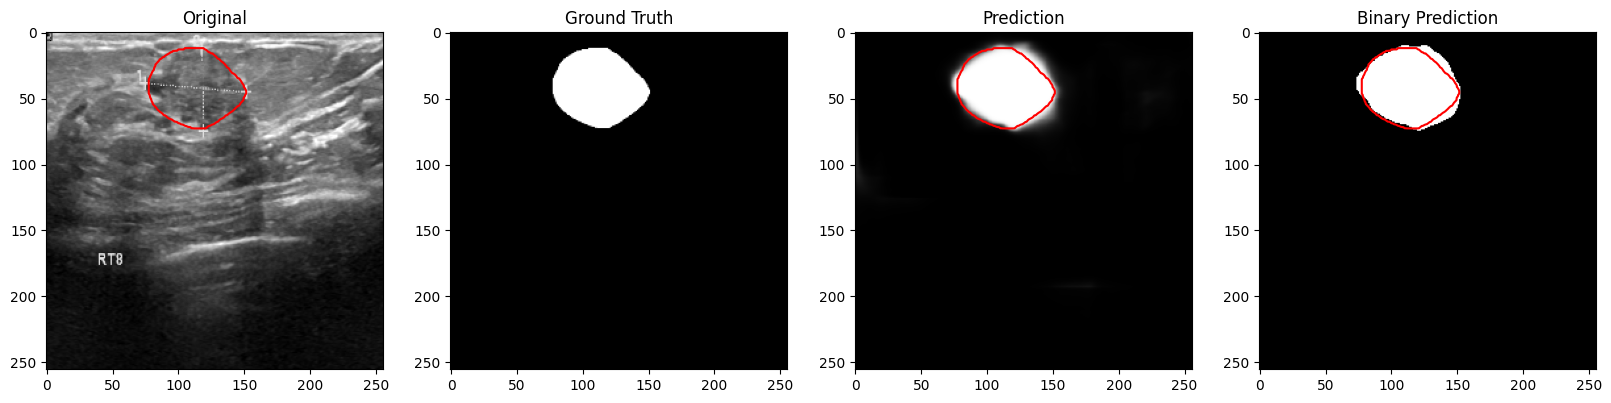

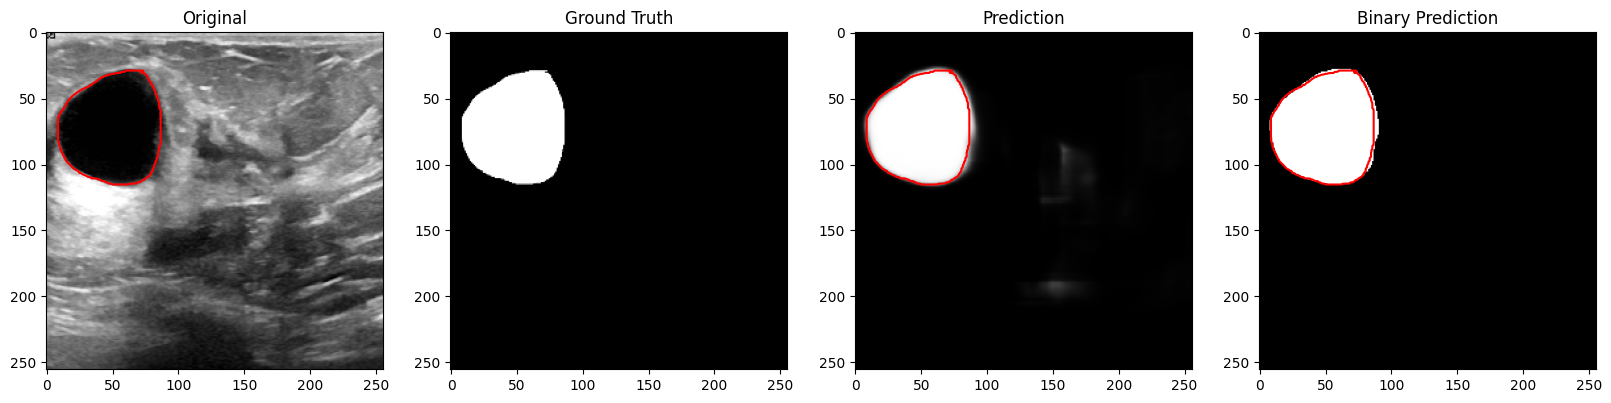

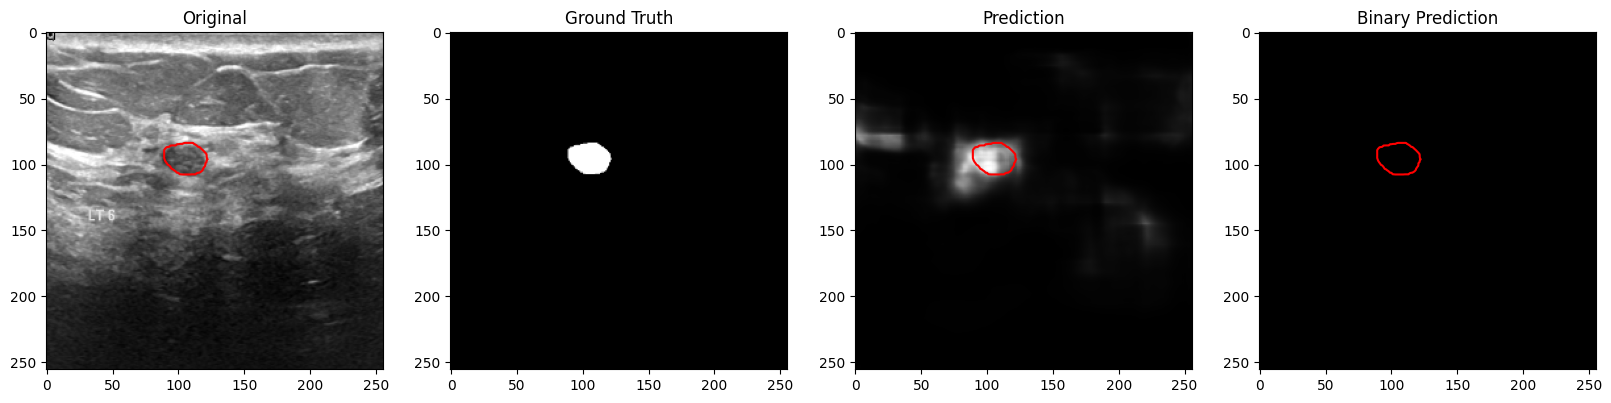

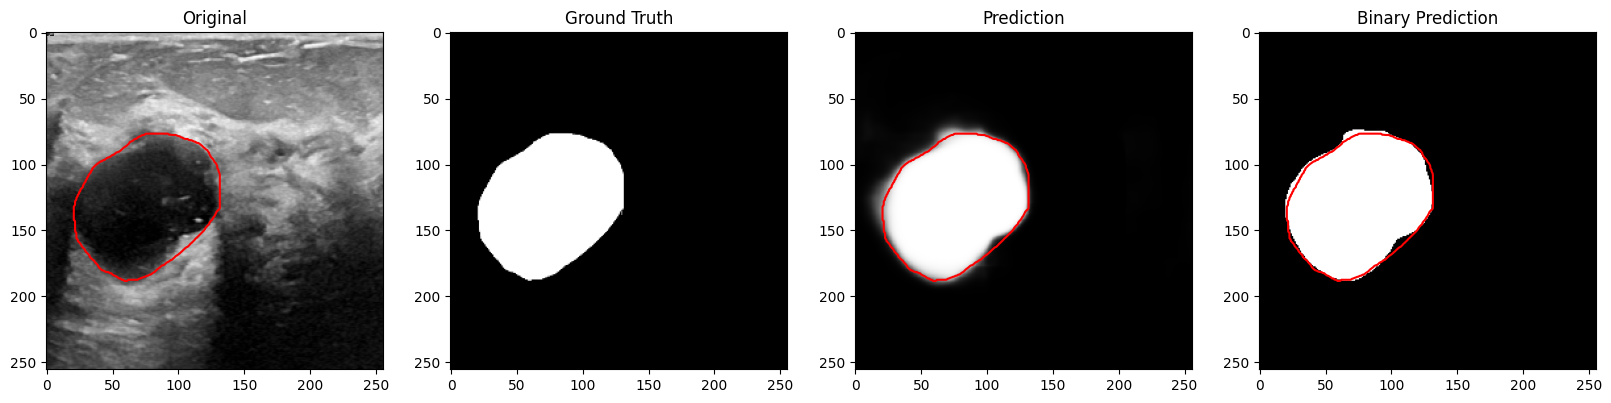

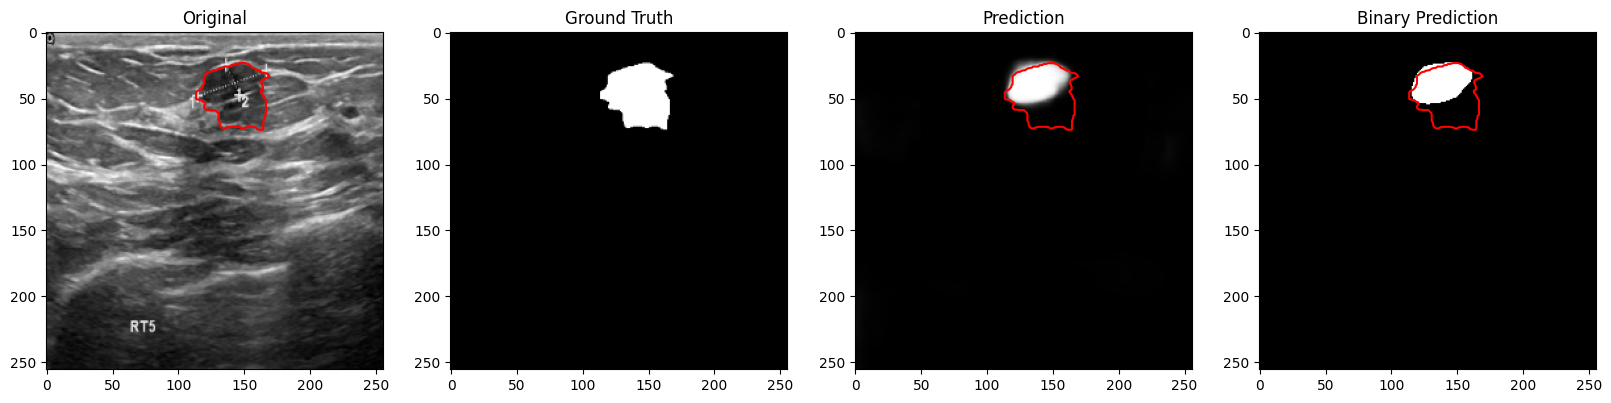

In [17]:
# Predict on the validation set and visualize results
preds_val = model.predict(X_test, verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Plot some examples
for i in range(5):
    plot_sample(X_test, y_test, preds_val, preds_val_t)

In [ ]:
import os
import json
from keras.models import model_from_json

# Create a directory to save the model files if it doesn't exist
os.makedirs('saved_model', exist_ok=True)

# Save the model architecture to a JSON file
model_json = model.to_json()
with open("saved_model/unet_model.json", "w") as json_file:
    json_file.write(model_json)

# # Save the model weights to an HDF5 file
# model.save_weights("saved_model/unet_model_weights.h5")

# print("Model architecture and weights saved successfully.")

In [ ]:
# Alternatively, save the model weights in multiple smaller files if the total size exceeds the GitHub limit
# This can be achieved by splitting the weight saving process into chunks
def save_weights_in_chunks(model, save_dir, max_size=50 * 1024 * 1024):
    os.makedirs(save_dir, exist_ok=True)
    weights = model.get_weights()
    chunk_index = 0
    total_size = 0

    for i, weight in enumerate(weights):
        weight_file = os.path.join(save_dir, f"weights_{i}.npy")
        np.save(weight_file, weight)
        total_size += os.path.getsize(weight_file)

        if total_size > max_size:
            chunk_index += 1
            total_size = 0

        if chunk_index > 0:
            chunk_file = os.path.join(save_dir, f"chunk_{chunk_index}.zip")
            os.system(f"zip -r {chunk_file} {save_dir}/*.npy")
            os.system(f"rm {save_dir}/*.npy")

save_weights_in_chunks(model, "saved_model/weights_chunks")

print("Model and weights saved successfully.")